
Columns after loading CSV: Index(['gender_encoded', 'suicidal_thoughts_encoded', 'family_history_encoded',
       'profession_Architect', 'profession_Chef', 'profession_Civil Engineer',
       'profession_Content Writer', 'profession_Digital Marketer',
       'profession_Doctor', 'profession_Educational Consultant',
       'profession_Entrepreneur', 'profession_Lawyer', 'profession_Manager',
       'profession_Pharmacist', 'profession_Student', 'profession_Teacher',
       'profession_UX/UI Designer', 'sleep_duration_encoded',
       'dietary_habits_encoded', 'degree_0', 'degree_1', 'degree_2',
       'degree_3', 'degree_4', 'city_encoded', 'id', 'Age',
       'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction',
       'Job Satisfaction', 'Work/Study Hours', 'Financial Stress',
       'Depression'],
      dtype='object')
IQR applied to Age: Removed 12 rows so far.
IQR applied to CGPA: Removed 9 rows so far.
Clipping applied to Academic Pressure: Capped to [0, 5].
Clippi

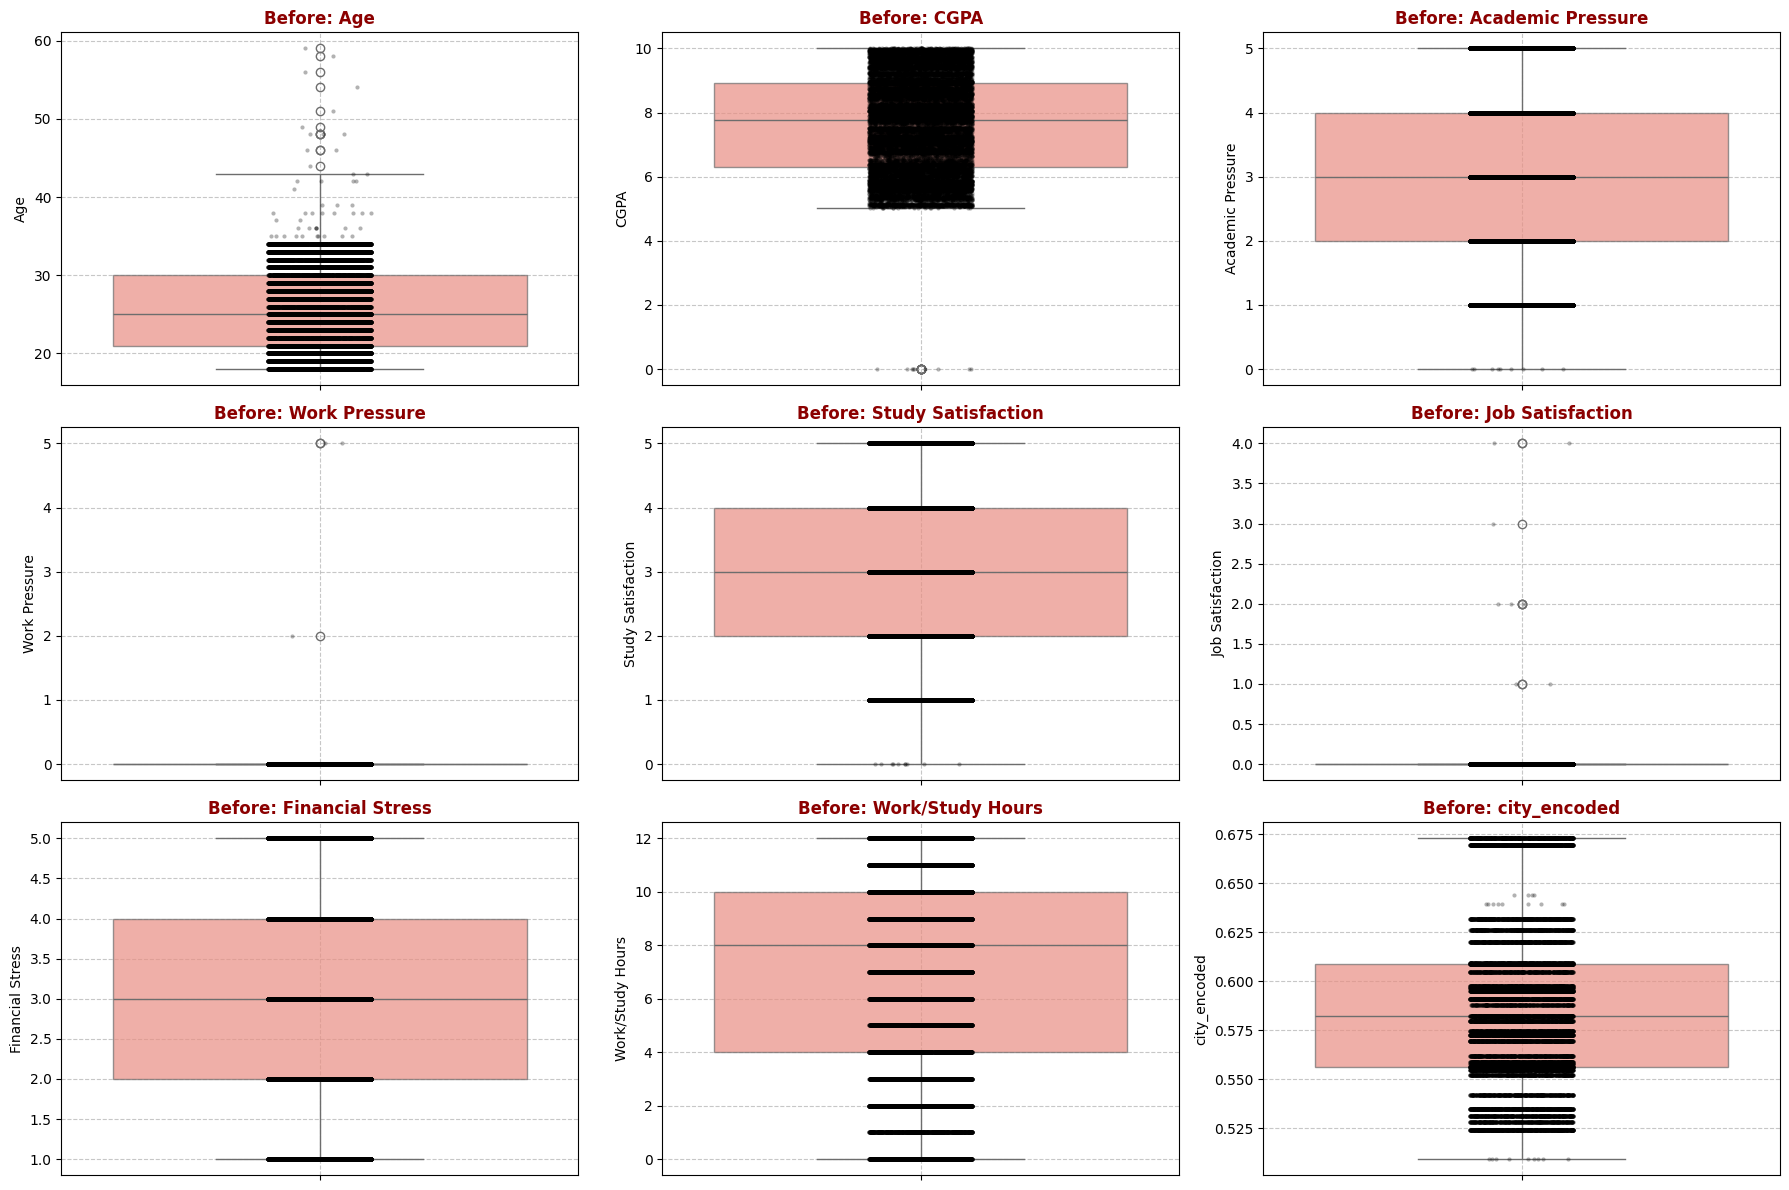

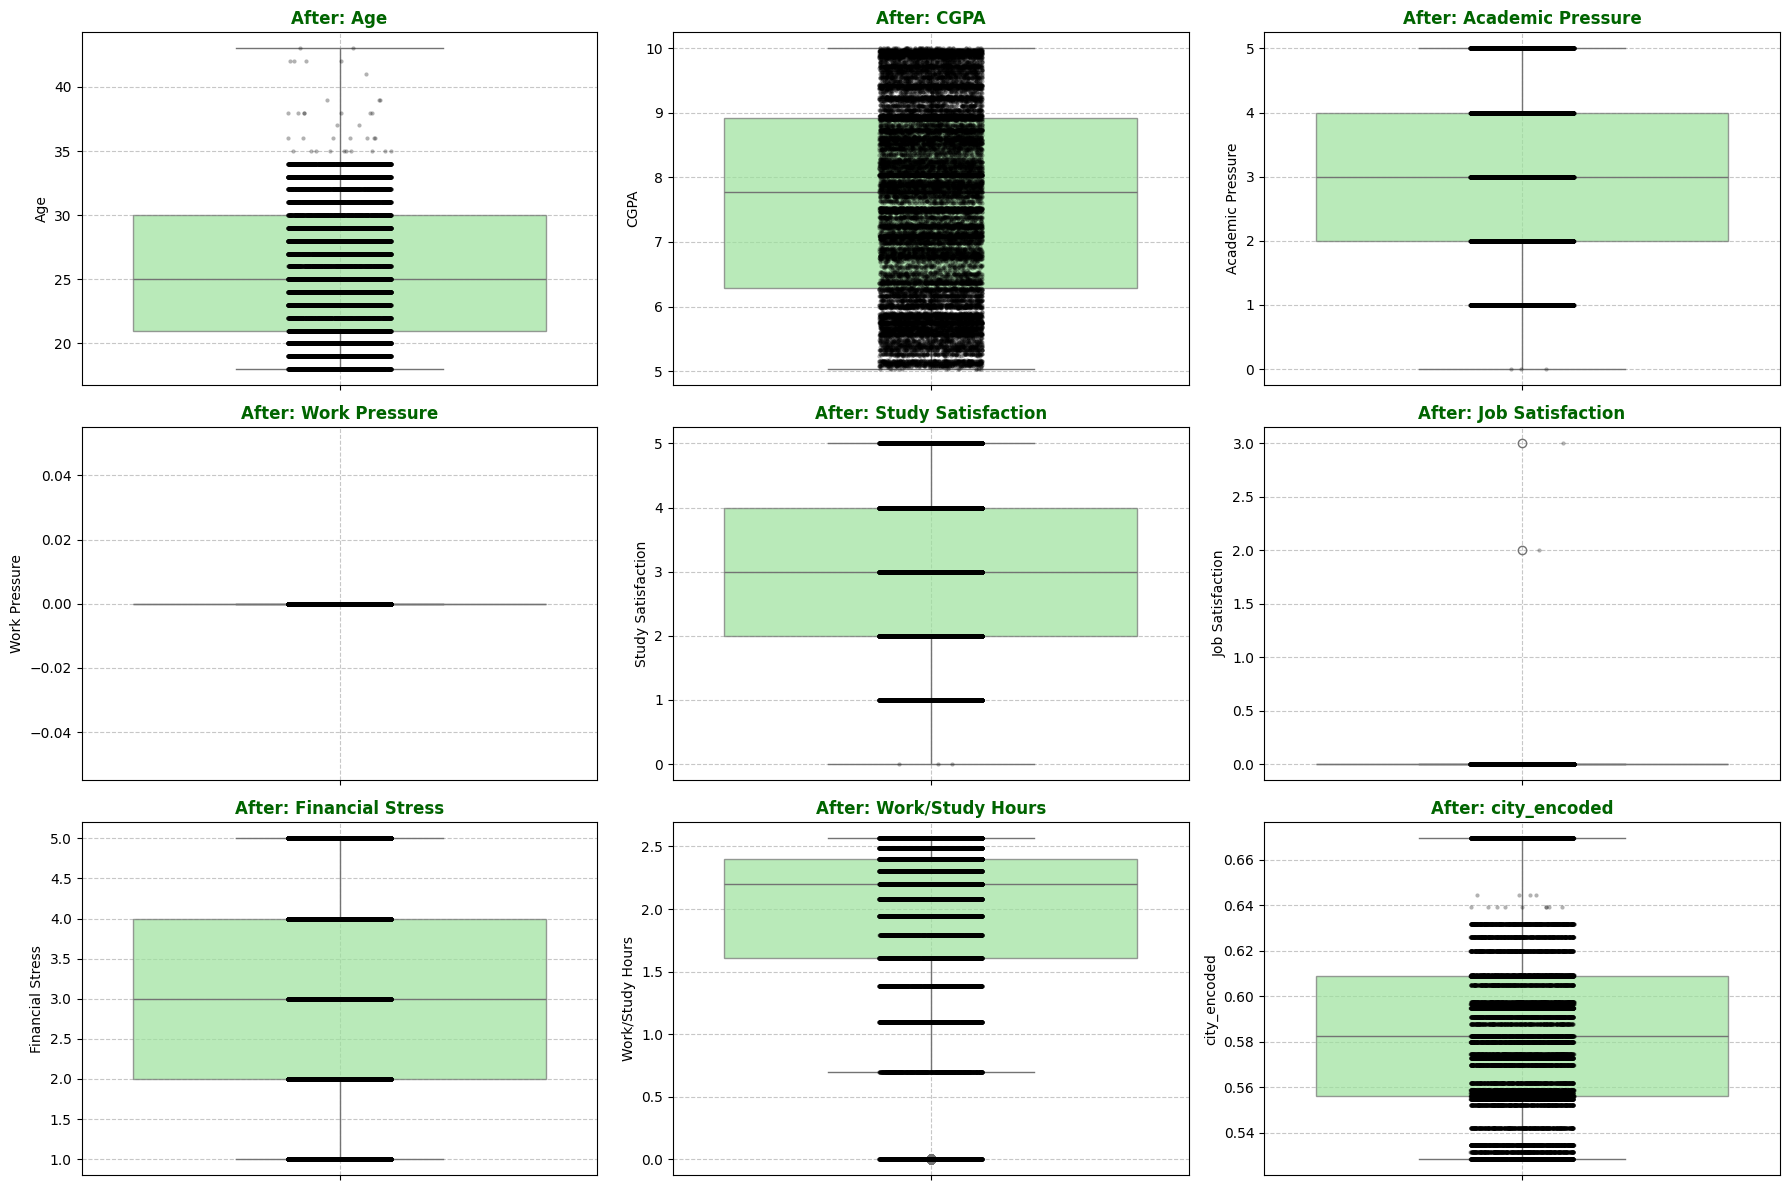


Cleaned dataset saved as 'outlier_handled_student_depression_dataset.csv'


In [3]:




# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the cleaned dataset
try:
    df = pd.read_csv('/content/fully_encoded_student_depression_dataset (4).csv')
    print("\nColumns after loading CSV:", df.columns) # Debugging line
except FileNotFoundError:
    print("Error: 'fully_encoded_student_depression_dataset.csv' not found. Please run the data cleaning step first.")
    exit()

# Copy original dataframe for comparison
df_original = df.copy()
df_cleaned = df.copy()

# Step 1: Define method-to-column mapping (as requested)
method_to_columns = {
    'iqr': ['Age', 'CGPA'],  # Removes outliers using IQR
    'clip': ['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Financial Stress'],  # Capped at 0-5
    'log': ['Work/Study Hours'],  # Log transformation to handle skewness
    'winsor': ['city_encoded']  # Winsorization after encoding (for categorical)
}

# Step 2: Define functions for each method
def apply_iqr_removal(df, columns):
    """Apply IQR method: Remove rows outside Q1 - 1.5*IQR to Q3 + 1.5*IQR."""
    initial_rows = len(df)
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].copy() # Added .copy() to avoid SettingWithCopyWarning
        print(f"IQR applied to {col}: Removed {initial_rows - len(df)} rows so far.")
        initial_rows = len(df) # Update initial_rows after each removal
    return df

def apply_clipping(df, columns, lower_bound=0, upper_bound=5):
    """Apply clipping: Cap values to [lower_bound, upper_bound]."""
    for col in columns:
        df.loc[:, col] = df[col].clip(lower_bound, upper_bound) # Use .loc to avoid SettingWithCopyWarning
        print(f"Clipping applied to {col}: Capped to [{lower_bound}, {upper_bound}].")
    return df

def apply_log_transformation(df, columns):
    """Apply log transformation: log(1 + x) to reduce skewness."""
    for col in columns:
        df.loc[:, col] = np.log1p(df[col]) # Use .loc to avoid SettingWithCopyWarning
        print(f"Log transformation applied to {col}.")
    return df

def apply_winsorization(df, columns, lower_percentile=0.05, upper_percentile=0.95):
    """Apply winsorization: Cap to percentiles (encode City first)."""
    for col in columns:
        # Winsorization is applied to the already encoded 'city_encoded' column
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]): # Add check for column existence and numeric dtype
            lower_bound = df[col].quantile(lower_percentile)
            upper_bound = df[col].quantile(upper_percentile)
            df.loc[:, col] = df[col].clip(lower_bound, upper_bound) # Use .loc to avoid SettingWithCopyWarning
            print(f"Winsorization applied to {col}: Capped at {lower_percentile*100}% and {upper_percentile*100}% percentiles.")
        else:
            print(f"Warning: Column '{col}' not found or is not numeric for winsorization.")
    return df

# Step 3: Apply methods based on mapping
for method, columns in method_to_columns.items():
    if method == 'iqr':
        df_cleaned = apply_iqr_removal(df_cleaned, columns)
    elif method == 'clip':
        df_cleaned = apply_clipping(df_cleaned, columns)
    elif method == 'log':
        df_cleaned = apply_log_transformation(df_cleaned, columns)
    elif method == 'winsor':
        print("\nColumns before winsorization:", df_cleaned.columns) # Debugging line
        df_cleaned = apply_winsorization(df_cleaned, columns)

# Step 4: Display summary
rows_before = len(df_original)
rows_after = len(df_cleaned)
print(f"\nSummary:")
print(f"Rows before outlier handling: {rows_before}")
print(f"Rows after outlier handling: {rows_after}")
print(f"Rows removed: {rows_before - rows_after}")

# Step 5: Enhanced EDA Visualizations (Before & After)
# Flatten column list for plotting
all_columns = sum(method_to_columns.values(), [])

plt.figure(figsize=(18, 12))
# Before handling
for i, col in enumerate(all_columns, 1):
    plt.subplot(3, 3, i)
    # Check if the original column exists in df_original before plotting
    if col in df_original.columns and df_original[col].dtype in ['float64', 'int64']:
        sns.boxplot(data=df_original, y=col, color='salmon', boxprops=dict(alpha=0.7))
        sns.stripplot(data=df_original, y=col, color='black', size=3, alpha=0.3)
        plt.title(f'Before: {col}', fontsize=12, fontweight='bold', color='darkred')
        plt.ylabel(col)
    elif col in df_original.columns and df_original[col].dtype == 'object': # Handle original categorical columns
        sns.countplot(data=df_original, x=col, palette='viridis', order=df_original[col].value_counts().index[:5])  # Top 5
        plt.title(f'Before: {col} (Top 5)', fontsize=12, fontweight='bold', color='darkred')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
    elif col in df_original.columns: # Handle encoded numerical columns including 'city_encoded'
        sns.boxplot(data=df_original, y=col, color='salmon', boxprops=dict(alpha=0.7))
        sns.stripplot(data=df_original, y=col, color='black', size=3, alpha=0.3)
        plt.title(f'Before: {col}', fontsize=12, fontweight='bold', color='darkred')
        plt.ylabel(col)

    plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.savefig('outliers_before_enhanced.png')
plt.show()

plt.figure(figsize=(18, 12))
# After handling
for i, col in enumerate(all_columns, 1):
    plt.subplot(3, 3, i)
    # Check if the cleaned column exists in df_cleaned before plotting
    if col in df_cleaned.columns and df_cleaned[col].dtype in ['float64', 'int64']:
        sns.boxplot(data=df_cleaned, y=col, color='lightgreen', boxprops=dict(alpha=0.7))
        sns.stripplot(data=df_cleaned, y=col, color='black', size=3, alpha=0.3)
        plt.title(f'After: {col}', fontsize=12, fontweight='bold', color='darkgreen')
        plt.ylabel(col)
    elif col in df_cleaned.columns and df_cleaned[col].dtype == 'object': # Handle original categorical columns
        sns.countplot(data=df_cleaned, x=col, palette='viridis', order=df_cleaned[col].value_counts().index[:5])  # Top 5
        plt.title(f'After: {col} (Top 5)', fontsize=12, fontweight='bold', color='darkgreen')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
    elif col in df_cleaned.columns: # Handle encoded numerical columns including 'city_encoded'
        sns.boxplot(data=df_cleaned, y=col, color='lightgreen', boxprops=dict(alpha=0.7))
        sns.stripplot(data=df_cleaned, y=col, color='black', size=3, alpha=0.3)
        plt.title(f'After: {col}', fontsize=12, fontweight='bold', color='darkgreen')
        plt.ylabel(col)

    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('outliers_after_enhanced.png')
plt.show()

# Step 6: Save cleaned dataset
df_cleaned.to_csv('outlier_handled_student_depression_dataset.csv', index=False)
print("\nCleaned dataset saved as 'outlier_handled_student_depression_dataset.csv'")